In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegressionCV, LassoCV, Lasso, ElasticNetCV, LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold

sys.path.append(os.path.abspath("../"))
from dmldid.model_rcs import DMLDiD_RCS

# original data processing
Somewhat improper processing, but we use the data pipeline of Chang (2020) as is to make the conditions the same as in the original paper.
https://github.com/NengChiehChang/Diff-in-Diff/blob/master/Table%202/DMLML.R

## issue
I have communicated the problems with this process in the  [issue](https://github.com/NengChiehChang/Diff-in-Diff/issues/1) of the original R repository.
The major problems are as follows: 
- Categorical variables should be explicitly binary processed
- inclusion of time binary T in the covariate

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R 
library(readstata13)
#Raw Data
data <- read.dta13 ("data/Bribes_Regression.dta")

Y=data$lba
D=data$tariff_change_2008
T=data$post_2008

clear_agent2=(data$clear_agent==2)
clear_agent3=(data$clear_agent==3)
clear_agent4=(data$clear_agent==4)
clear_agent5=(data$clear_agent==5)
clear_agent6=(data$clear_agent==6)
clear_agent7=(data$clear_agent==7)
clear_agent8=(data$clear_agent==8)

hc_group2=(data$hc_group==2)
hc_group3=(data$hc_group==3)
hc_group4=(data$hc_group==4)
hc_group5=(data$hc_group==5)
hc_group6=(data$hc_group==6)
hc_group7=(data$hc_group==7)
hc_group8=(data$hc_group==8)
hc_group9=(data$hc_group==9)
hc_group10=(data$hc_group==10)
hc_group11=(data$hc_group==11)
hc_group12=(data$hc_group==12)
hc_group13=(data$hc_group==13)
hc_group14=(data$hc_group==14)
hc_group15=(data$hc_group==15)


X=cbind(data$post_2008, data$tariff2007,data$lvalue_tonnage, data$differentiated, data$agri, data$perishable,data$dfs, data$day_w_arrival, data$monitor, data$psi, data$rsa, data$post_2008,clear_agent2,clear_agent3,clear_agent4,clear_agent5,clear_agent6,clear_agent7,clear_agent8,hc_group2,hc_group3,hc_group4,hc_group5,hc_group6,hc_group7,hc_group8,hc_group9,hc_group10,hc_group11,hc_group12,hc_group13,hc_group14,hc_group15,data$hc_4digit)

#Working data
Working_data=cbind(Y,D,T,X)

Working_data=Working_data[complete.cases(Working_data), ]

Y=Working_data[,1]
D=Working_data[,2]
T=Working_data[,3]
X=Working_data[,4:12]


In [4]:
%R -o Y
%R -o D
%R -o T
%R -o X

In [5]:
Working_data = pd.DataFrame(
    {
        "Y": Y,
        "D": D,
        "T": T,
    }
)
_x = pd.DataFrame(X)
_x = _x.add_prefix("x")
Working_data = pd.concat([Working_data, _x], axis=1)

y_col = "Y"
d_col = "D"
t_col = "T"
X_cols = _x.columns
Working_data.head()

,Y,D,T,x0,x1,x2,x3,x4,x5,x6,x7,x8
0,0.000000,1.0,1.0,1.0,20.0,6.239789,1.0,0.0,0.0,0.0,1.0,1.0
1,9.814213,0.0,1.0,1.0,20.0,10.423183,1.0,1.0,0.0,0.0,3.0,1.0
2,0.000000,0.0,1.0,1.0,20.0,9.832332,1.0,1.0,0.0,0.0,4.0,1.0
3,0.000000,0.0,1.0,1.0,7.5,3.246811,1.0,0.0,0.0,0.0,2.0,1.0
4,0.000000,0.0,1.0,1.0,20.0,4.179014,0.0,1.0,1.0,0.0,7.0,1.0


In [6]:
print(Working_data.shape)

(1084, 12)


In [7]:
model_df = Working_data.copy()

In [8]:
_pivot =  pd.pivot_table(model_df, values="Y", index="D", columns="T", aggfunc="mean")
_pivot["diff"] = _pivot.diff(axis=1)[1]
_pivot = pd.concat([_pivot, _pivot.diff().tail(1)])
_pivot.index=["0", "1", "diff"]
_pivot

T,0.0,1.0,diff
0,2.918704,0.912785,-2.005919
1,8.417057,1.183349,-7.233708
diff,5.498353,0.270564,-5.227789


# Checking PS common support

In [9]:
K = 2
df_set = train_test_split(model_df, random_state=1, test_size=0.5)
for i in range(K):
    k = 0 if i == 0 else 1
    c = 1 if i == 0 else 0
    d_model = LogisticRegressionCV(cv=5, random_state=0, penalty='l1', solver='saga')
    d_model.fit(df_set[c][X_cols],  df_set[c][d_col])
    df_set[k]["ps_lasso"] = d_model.predict_proba(df_set[k][X_cols])[:, 1]
    
    d_model = LGBMClassifier(max_depth=10, random_state=0)
    d_model.fit(df_set[c][X_cols],  df_set[c][d_col])
    df_set[k]["ps_lgbm"] = d_model.predict_proba(df_set[k][X_cols])[:, 1]
    

In [10]:
ps_check_df = pd.concat(df_set,axis=0)
ps_check_df.head()

,Y,D,T,x0,x1,x2,x3,x4,x5,x6,x7,x8,ps_lasso,ps_lgbm
305,0.000000,0.0,1.0,1.0,0.0,6.856199,0.0,0.0,0.0,1.0,3.0,1.0,0.640385,0.044128
605,0.000000,0.0,1.0,1.0,20.0,10.108861,1.0,1.0,0.0,0.0,7.0,1.0,0.007212,0.000070
577,0.000000,0.0,1.0,1.0,5.0,10.890318,1.0,0.0,0.0,0.0,2.0,2.0,0.163405,0.000726
956,0.000000,0.0,1.0,1.0,20.0,10.108698,1.0,1.0,0.0,0.0,6.0,1.0,0.006829,0.000077
285,8.409576,0.0,1.0,1.0,0.0,5.831149,1.0,0.0,0.0,0.0,3.0,1.0,0.244158,0.003421


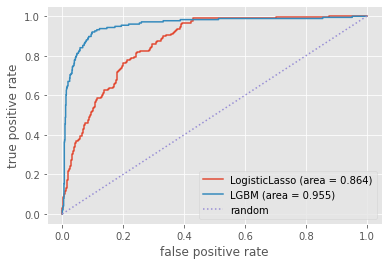

In [11]:
auc_score_lasso = roc_auc_score(y_true=ps_check_df["D"], y_score=ps_check_df["ps_lasso"])
auc_score_lgbm = roc_auc_score(y_true=ps_check_df["D"], y_score=ps_check_df["ps_lgbm"])

fpr, tpr, thresholds = roc_curve(y_true=ps_check_df["D"], y_score=ps_check_df["ps_lasso"])
plt.plot(fpr, tpr, label="LogisticLasso (area = %0.3f)" % auc_score_lasso )
fpr, tpr, thresholds = roc_curve(y_true=ps_check_df["D"], y_score=ps_check_df["ps_lgbm"])
plt.plot(fpr, tpr, label="LGBM (area = %0.3f)" % auc_score_lgbm )
plt.plot([0, 1], [0, 1], linestyle=":", label="random")

plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.show()

High enough to suspect a little leakage....

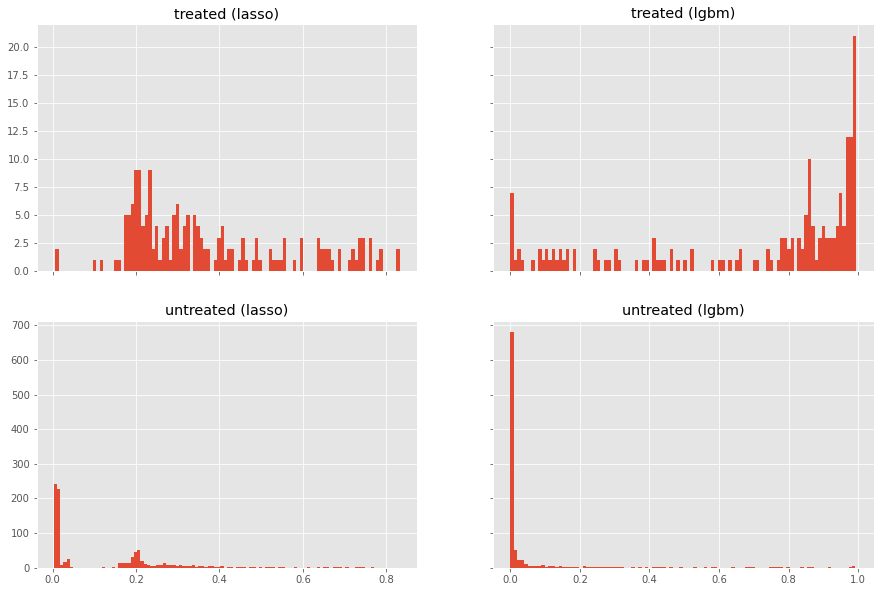

In [12]:
fig, ax = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(15, 10))
ax = ax.ravel()

ps_check_df.query("D>0")["ps_lasso"].hist(bins=100, ax=ax[0])
ax[0].set_title("treated (lasso)")

ps_check_df.query("D>0")["ps_lgbm"].hist(bins=100, ax=ax[1])
ax[1].set_title("treated (lgbm)")

ps_check_df.query("D<1")["ps_lasso"].hist(bins=100, ax=ax[2])
ax[2].set_title("untreated (lasso)")

ps_check_df.query("D<1")["ps_lgbm"].hist(bins=100, ax=ax[3])
ax[3].set_title("untreated (lgbm)")

plt.show()

- Even the default parameters for LGBM are too predictive and the common support for PS is too narrow.
- In the following we use lasso

In [13]:
# The support of the ps of the treated is a subset of the support for the untreated
tg_cutpoint = pd.qcut(ps_check_df.query("D > 0")["ps_lasso"], 10).unique()


def adjust_cutpoint(x):
    try:
        return [_point for _point in tg_cutpoint if x in _point][0]
    except:
        return "ommit_data"


ps_check_df["ps_group"] = ps_check_df["ps_lasso"].apply(adjust_cutpoint)

pd.pivot_table(ps_check_df, values="Y", index="D", columns="ps_group", aggfunc="count")

ps_group,"(0.00517, 0.194]","(0.194, 0.208]","(0.208, 0.232]","(0.232, 0.276]","(0.276, 0.313]","(0.313, 0.357]","(0.357, 0.432]","(0.432, 0.558]","(0.558, 0.7]","(0.7, 0.832]",ommit_data
D,,,,,,,,,,,
0.0,588,90,54,47,34,25,28,13,11,6,12
1.0,18,18,17,18,17,18,17,18,17,17,1


In [14]:
def cal_abs_mean_diff(df):
    # (avg_d=1 - avg_d=0) / std
    return (
        (
            df.query("D>0").drop("D", axis=1).mean()
            - df.query("D<1").drop("D", axis=1).mean()
        )
        / df.drop("D", axis=1).std()
    ).abs()

unadjusted_balance = cal_abs_mean_diff(ps_check_df[list(X_cols) + ["D"]])

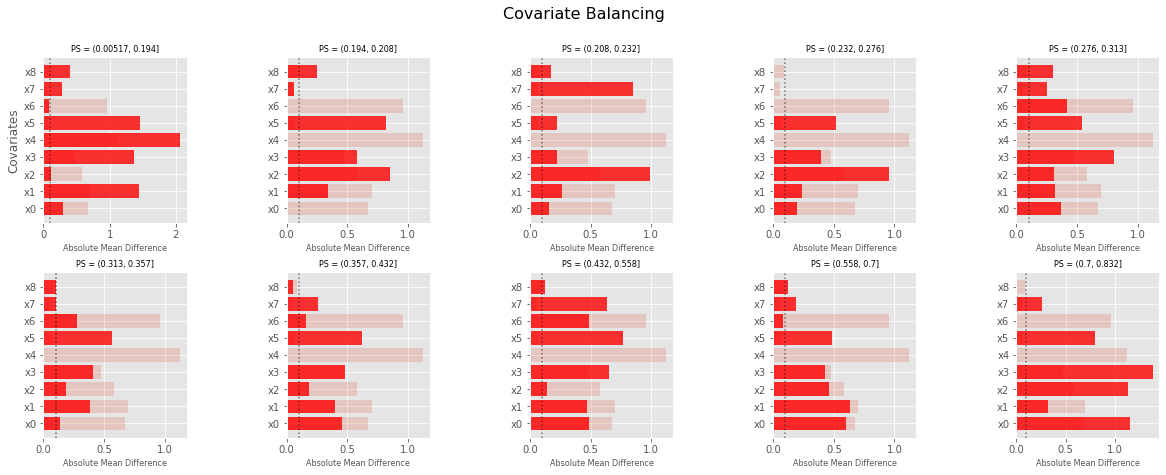

In [15]:
# 本当に特徴量がバランシングできているか確認する
ps_check_df["ps_group"] = ps_check_df["ps_group"].astype("str")
cutpoint_list = [
    cutpoint for cutpoint in ps_check_df["ps_group"].unique() if cutpoint != "ommit_data"
]
cutpoint_list = sorted(cutpoint_list)

fig, ax = plt.subplots(nrows=2,ncols=5, figsize=(20, 7))
plt.subplots_adjust(wspace=0.7,hspace=0.3)
ax = ax.ravel()
for i, cutpoint in enumerate(cutpoint_list):
    _group = ps_check_df.query("ps_group == @cutpoint")
    _group_balance = cal_abs_mean_diff(
        _group[
            list(X_cols) + ["D"]
        ]
    )
    if i == 0:
        ax[i].set_ylabel("Covariates", fontsize=12)

    ax[i].set_title(f"PS = {cutpoint}", fontsize=8)
    ax[i].set_xlabel("Absolute Mean Difference", fontsize=8)
    ax[i].barh(unadjusted_balance.index, unadjusted_balance, alpha=0.2)
    ax[i].barh(_group_balance.index, _group_balance, alpha=0.8, color="r")
    ax[i].axvline(x=0.1,alpha=0.5, color="black",linestyle="dotted")
fig.suptitle("Covariate Balancing", fontsize=16)
plt.show()

# Chang(2020)

- fixed_DMLM : Functions with obvious implementation errors corrected.

In [16]:
%%R

library(glmnet)

p=X
DMLML=function(Y,D,p,T){
  N=length(Y)
  B=100
  set.seed(123)
  random=sample(1:1000,B)
  
  thetabar=c(0)
  for (l in 1:B){
    k=2
    samplesplit=function(k,N){
      c1=1:N
      smp_size <- floor((1/k) * length(c1))
      
      ## set the seed to make your partition reproducible
      set.seed(random[l])
      train_ind <- sample(seq_len(length(c1)), size = smp_size)
      
      k1 <- c1[train_ind]
      k2 <- c1[-train_ind]
      return(rbind(k1,k2))
    }
    K=samplesplit(k,N)
    
    thetaDML=c(0)
    
    for (q in 1:k){
      ##Trimming
      set.seed(333)
      CV=cv.glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1)
      fit=glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1,lambda=CV$lambda.1se)
      beta1hat=fit$beta
      beta1hat <- as.numeric(as.character(beta1hat))
      
      ghat=1/(1+exp(-p[K[q,],]%*%beta1hat))
      #ghat = predict(fit, p[K[q,],], type="response")
      
      index1=K[q,][which(ghat<0.97 & ghat>0.03)]
      
      ##Estimation
      ghat=1/(1+exp(-p[index1,]%*%beta1hat))
      #ghat = predict(fit, p[index1,], type="response")
      
      lambda=mean(T[-K[q,]])
      
      index=which(D[-K[q,]]==0)
      YY=Y[-K[q,]]
      YY=YY[index]
      TT=T[-K[q,]]
      TT=TT[index]
      XX=p[-K[q,],]
      XX=XX[index,]
      
      set.seed(333)
      CV=cv.glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1)
      fit=glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1,lambda=CV$lambda.1se)
      
      beta2hat=fit$beta
      beta2hat <- as.numeric(as.character(beta2hat))
      
      ellhat2=p[index1,]%*%beta2hat
      #ellhat2 = predict(fit,p[index1,])
      
      
      s=((T[index1]-lambda)*Y[index1]-ellhat2)*(D[index1]-ghat)/(1-ghat)/(lambda*(1-lambda))/mean(D[index1])
      s=s[which(s<abs(min(s)))]
      
      thetaDML[q]=mean(s)
      
    }
    thetabar[l]=mean(thetaDML)
  }
  finaltheta=mean(thetabar)
  return(thetabar)
}

fixed_DMLML=function(Y,D,p,T){
  N=length(Y)
  B=100
  set.seed(123)
  random=sample(1:1000,B)
  
  thetabar=c(0)
  for (l in 1:B){
    k=2
    samplesplit=function(k,N){
      c1=1:N
      smp_size <- floor((1/k) * length(c1))
      
      ## set the seed to make your partition reproducible
      set.seed(random[l])
      train_ind <- sample(seq_len(length(c1)), size = smp_size)
      
      k1 <- c1[train_ind]
      k2 <- c1[-train_ind]
      return(rbind(k1,k2))
    }
    K=samplesplit(k,N)
    
    thetaDML=c(0)
    
    for (q in 1:k){
      ##Trimming
      set.seed(333)
      CV=cv.glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1)
      fit=glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1,lambda=CV$lambda.1se)
      beta1hat=fit$beta
      beta1hat <- as.numeric(as.character(beta1hat))
      
      #ghat=1/(1+exp(-p[K[q,],]%*%beta1hat))
      ghat = predict(fit, p[K[q,],], type="response")
      
      index1=K[q,][which(ghat<0.97 & ghat>0.03)]
      
      ##Estimation
      #ghat=1/(1+exp(-p[index1,]%*%beta1hat))
      ghat = predict(fit, p[index1,], type="response")
      
      lambda=mean(T[-K[q,]])
      
      index=which(D[-K[q,]]==0)
      YY=Y[-K[q,]]
      YY=YY[index]
      TT=T[-K[q,]]
      TT=TT[index]
      XX=p[-K[q,],]
      XX=XX[index,]
      
      set.seed(333)
      CV=cv.glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1)
      fit=glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1,lambda=CV$lambda.1se)
      
      beta2hat=fit$beta
      beta2hat <- as.numeric(as.character(beta2hat))
      
      #ellhat2=p[index1,]%*%beta2hat
      ellhat2 = predict(fit,p[index1,])
      
      
      s=((T[index1]-lambda)*Y[index1]-ellhat2)*(D[index1]-ghat)/(1-ghat)/(lambda*(1-lambda))/mean(D[index1])
      # s=s[which(s<abs(min(s)))]
      
      thetaDML[q]=mean(s)
      
    }
    thetabar[l]=mean(thetaDML)
  }
  finaltheta=mean(thetabar)
  return(thetabar)
}
r_result = DMLML(Y,D,p,T)
fixed_r_result = fixed_DMLML(Y,D,p,T)

R[write to console]:  要求されたパッケージ Matrix をロード中です 

R[write to console]: Loaded glmnet 4.1-3



In [17]:
%R -o r_result
%R -o fixed_r_result

- This is a reproduction of the original DMLDID (Chang 2020) .
- It is implemented with a parameter that determines whether or not to correct an obvious implementation error.

In [18]:
def original_dmldid_rcs(
    df,
    y_col,
    d_col,
    t_col,
    X_cols,
    d_model=LogisticRegressionCV(cv=5, random_state=0, penalty="l1", solver="saga"),
    l2k_model=LassoCV(cv=5, random_state=0),
    original=True,
):
    B = 100
    K = 2  # ２分割

    thetabar = []

    for l in tqdm(range(B)):
        df_set = train_test_split(df, random_state=l, test_size=0.5)
        _thetabar = []
        for i in range(K):
            k = 0 if i == 0 else 1
            c = 1 if i == 0 else 0

            d_model.fit(df_set[c][X_cols], df_set[c][d_col])

            eps = 0.03

            if original and hasattr(d_model, "coef_"):
                z = df_set[k][X_cols] @ d_model.coef_.T
                ghat = np.clip(
                    1 / (1 + np.exp(-1 * z)),
                    eps,
                    1 - eps,
                    )
                ghat = [_g[0] for _g in ghat.values]
                ghat = np.array(ghat, dtype=float)
            else:
                ghat = np.clip(
                    d_model.predict_proba(df_set[k][X_cols])[:, 1],
                    eps,
                    1 - eps,
                )
            
            lamda_hat = df_set[c][t_col].mean()

            if original:
                p_hat = df_set[k][d_col].mean()  # 本当はｃでは？
            else:
                p_hat = df_set[c][d_col].mean()

            control_y = df_set[c].query(f"{d_col} < 1")[y_col]
            control_t = df_set[c].query(f"{d_col} < 1")[t_col]
            control_x = df_set[c].query(f"{d_col} < 1")[X_cols]

            _y = (control_t - lamda_hat) * control_y

            l2k_model.fit(control_x, _y)

            if original and hasattr(l2k_model, "coef_"):
                l2k_hat = df_set[k][X_cols] @ l2k_model.coef_.T  # 間違い　切片が消えてる
            else:
                l2k_hat = l2k_model.predict(df_set[k][X_cols])

            _c = (
                ((df_set[k][t_col] - lamda_hat) * df_set[k][y_col] - l2k_hat)
                * (df_set[k][d_col] - ghat)
                / ((1 - ghat) * lamda_hat * (1 - lamda_hat) * p_hat)
            )

            if original:
                _thetabar.append(_c[_c <= abs(_c.min())].mean())
            else:
                _thetabar.append(_c.mean())

        thetabar.append(np.mean(_thetabar))
    return thetabar

In [19]:
original_bar = original_dmldid_rcs(model_df, y_col, d_col, t_col, X_cols)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


In [20]:
few_fixed_bar = original_dmldid_rcs(model_df, y_col, d_col, t_col, X_cols, original=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


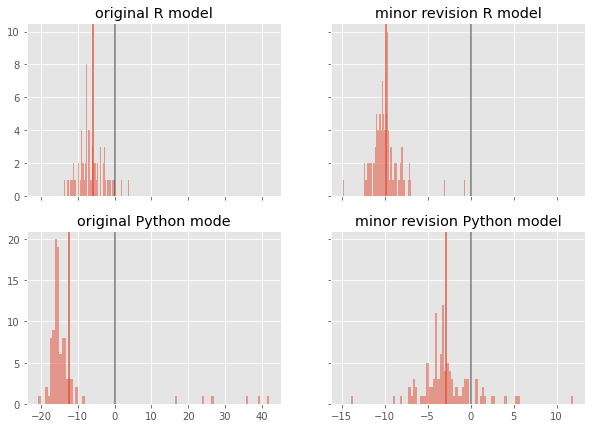

In [22]:
_label = [
    "original R model",
    "minor revision R model",
    "original Python mode",
    "minor revision Python model",
]
result_df = pd.DataFrame(
    {
        "original_bar": r_result,
        "few_fixed_bar": fixed_r_result,
        "original_bar_python" : original_bar,
        "few_fixed_bar_python": few_fixed_bar,
    }
)
fig, ax = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 7))
ax = ax.ravel()
for i, _col in enumerate(result_df.columns):
    ax[i].hist(result_df[_col], bins=100, alpha=0.5)
    # ax[i].set_xlim(0,5)
    ax[i].set_title(_label[i])
    ax[i].axvline(x=0, alpha=0.5, color="black")
    ax[i].axvline(x=result_df[_col].mean(), alpha=0.9)
plt.show()

In [23]:
result_df.describe().T

,count,mean,std,min,25%,50%,75%,max
original_bar,100.0,-5.892878,3.742364,-13.696808,-8.403724,-6.625829,-3.696101,4.848805
few_fixed_bar,100.0,-9.901200,1.747608,-14.865869,-10.819797,-10.074679,-9.459064,-0.671385
original_bar_python,100.0,-12.365827,11.339253,-20.699300,-16.076267,-15.328241,-13.662435,42.036337
few_fixed_bar_python,100.0,-2.851134,3.210022,-13.973163,-4.169604,-3.276015,-1.858089,11.948624


# My solution:
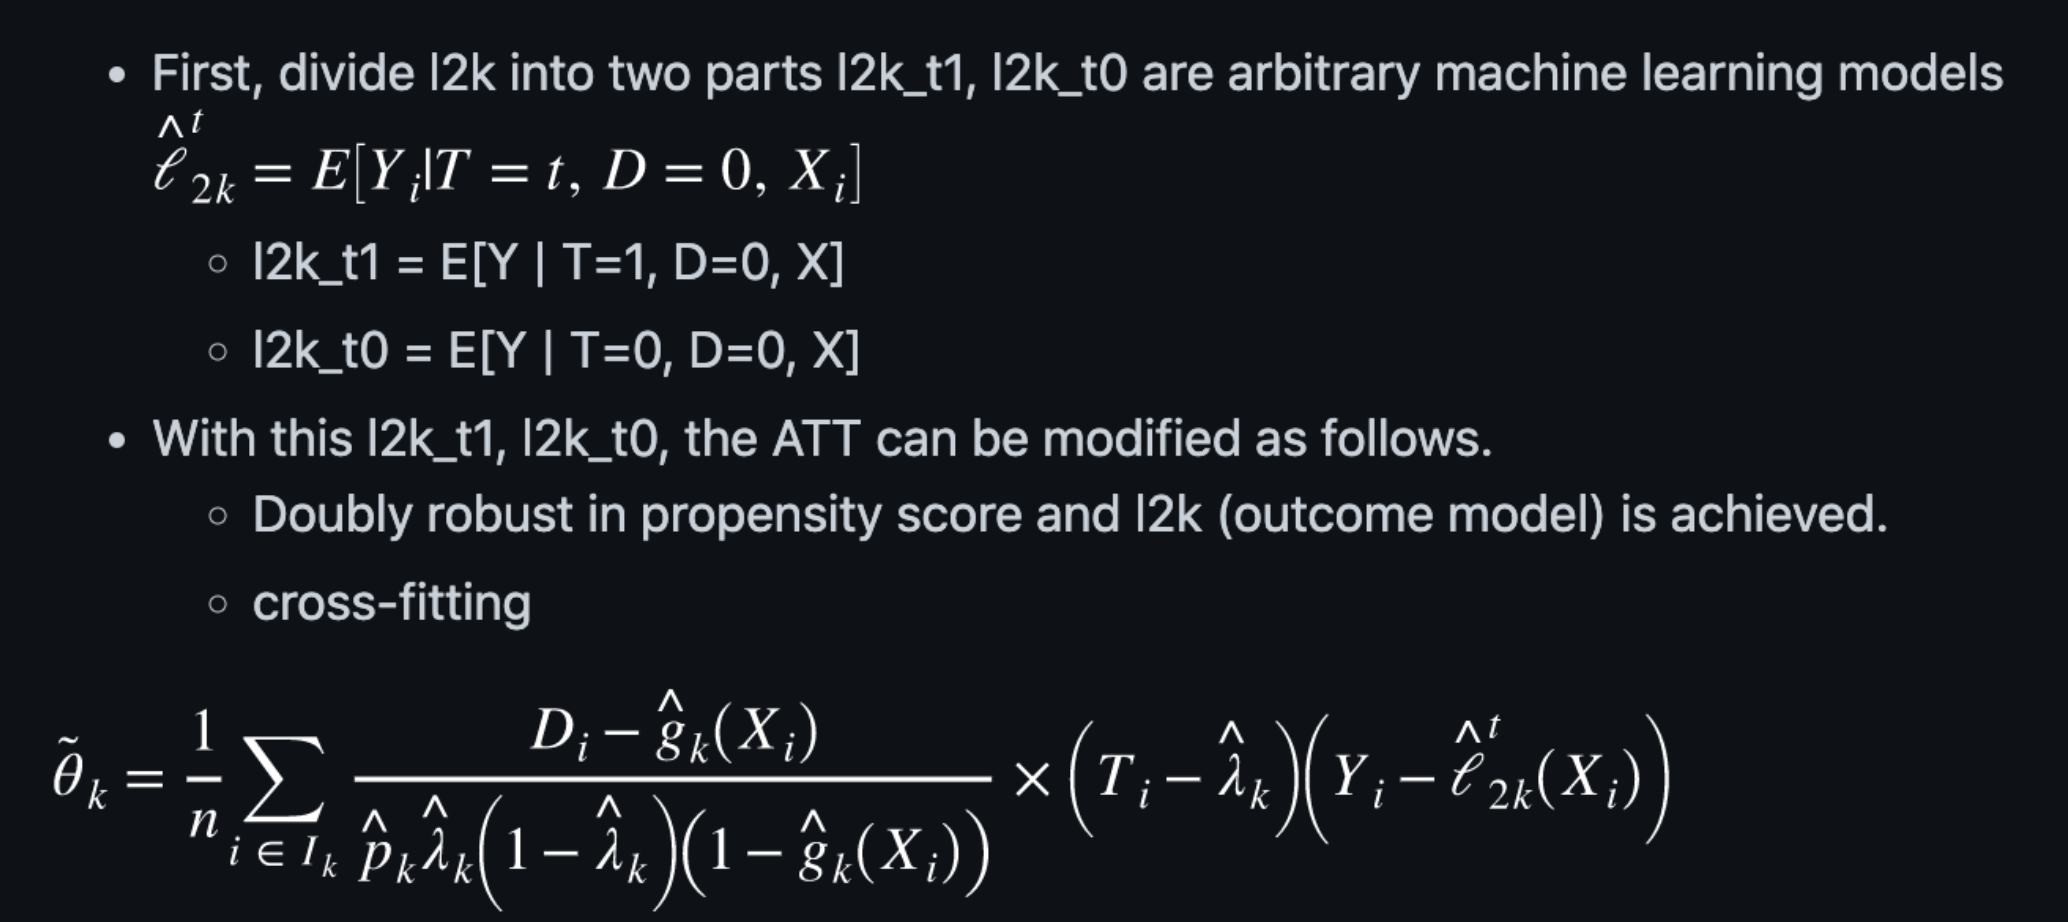

In [24]:
linear_dmldid = DMLDiD_RCS()

lgbm_dmldid = DMLDiD_RCS(
    d_model=LGBMClassifier(random_state=0),
    l2k_model=LGBMRegressor(random_state=0),
)

In [25]:
linear_dmldid.fit(
    model_df,
    y_col,
    d_col,
    t_col,
    X_cols,
    dmldid=True,
    sim_cnt=100,
    base_random_seed=0,
    progress_plot=True,
    d_model_t0_only=True,
)
algo_modified_bar = linear_dmldid.sim_att_result()

99. att :  3.3456762287232222


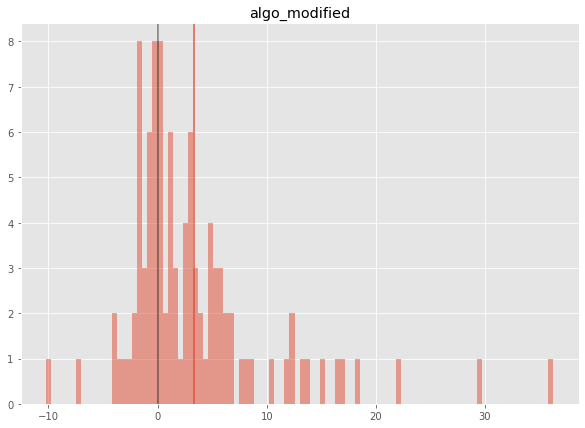

In [26]:
fig, ax = plt.subplots(1, 1, sharex="col", sharey="row", figsize=(10, 7))


ax.hist(algo_modified_bar , bins=100, alpha=0.5)

ax.set_title("algo_modified")
ax.axvline(x=0, alpha=0.5, color="black")
ax.axvline(x=np.mean(algo_modified_bar), alpha=0.9)
plt.show()